# Imports

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import dask.dataframe as dd
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from function import text_processing, STOP_WORDS, sentiment_scores

In [12]:
df = pickle.load( open( "data.p", "rb" ) )
print("Shape of the data: ",df.shape)
df.head()

Shape of the data:  (1290534, 12)


userid            location  totaltweets       tweetid  \
2            1927022036  Göttingen, Germany         78.0  1.496739e+18   
7   1350117145498173441      Chennai, India       2391.0  1.496739e+18   
20           3518882836            Pakistan       6379.0  1.496739e+18   
34   995425560825417733            Honduras       1437.0  1.496739e+18   
45             25645618       New York, USA     133271.0  1.496739e+18   

    retweetcount                                           hashtags  \
2            0.0  [{'text': 'Putin', 'indices': [13, 19]}, {'tex...   
7            1.0           [{'text': 'ரஷ்யா', 'indices': [27, 33]}]   
20          29.0          [{'text': 'Mascow', 'indices': [89, 96]}]   
34        3476.0  [{'text': 'Ucrania', 'indices': [47, 55]}, {'t...   
45         227.0  [{'text': 'Russia', 'indices': [60, 67]}, {'te...   

                   extractedts    location_clean       country  \
2   2022-02-24 06:51:34.412324  gttingen germany       germany   
7   2022-02-24 06:51:34.366602     chennai india         india   
20  2022-02-24 06:51:34.247277          pakistan      pakistan   
34  2022-02-24 06:51:34.096536          honduras      honduras   
45  2022-02-24 06:51:33.879973      new york usa  united state   

                                           text_clean      tweet_datetime  \
2   die rede von ist echt gruselig russland ist fr... 2022-02-24 06:48:02   
7                      ukrainerussie america worldwar 2022-02-24 06:48:03   
20  historic moment pm pakistan mr imran khan land... 2022-02-24 06:48:04   
34  hay que bromear esto ucrania terceraguerramund... 2022-02-24 06:48:04   
45  ka armyansk crimea ukrainewar russiawar europe... 2022-02-24 06:48:05   

    tweet_date  
2   2022-02-24  
7   2022-02-24  
20  2022-02-24  
34  2022-02-24  
45  2022-02-24

# Preprocessing

In [14]:
df_count_tweets = df.groupby('userid', as_index=False).count() \
                                    .sort_values(by='text_clean', ascending=False)[['userid', 'text_clean']]

df_count_tweets = df_count_tweets.rename(columns = {'text_clean': '#tweets'})
df_count_tweets

userid  #tweets
188166   786536017541025792     1959
14357              27007409     1554
15534              29123084     1316
252410  1199768132832776193     1238
226698  1027709464906948610     1164
...                     ...      ...
187124   780572765875081216        1
45432             116505663        1
187127   780575989541711872        1
45431             116504600        1
367167   999990545434005504        1

[367168 rows x 2 columns]

In [13]:
df = df.merge(df_count_tweets, on='userid', how='inner').sort_values(by='#tweets', ascending=False)
df.head()

userid            location  totaltweets       tweetid  \
368690  786536017541025792  Kendari, Indonesia       8726.0  1.501382e+18   
369387  786536017541025792  Kendari, Indonesia       9532.0  1.503194e+18   
369385  786536017541025792  Kendari, Indonesia       9532.0  1.503194e+18   
369384  786536017541025792  Kendari, Indonesia       9532.0  1.503194e+18   
369383  786536017541025792  Kendari, Indonesia       9532.0  1.503194e+18   

        retweetcount                                           hashtags  \
368690           0.0  [{'text': 'StopWarInUkraine', 'indices': [137,...   
369387           0.0  [{'text': 'ukraina', 'indices': [101, 109]}, {...   
369385           0.0  [{'text': 'ukraina', 'indices': [101, 109]}, {...   
369384           0.0  [{'text': 'ukraina', 'indices': [98, 106]}, {'...   
369383           0.0  [{'text': 'ukraina', 'indices': [99, 107]}, {'...   

                       extractedts     location_clean    country  \
368690  2022-03-09 02:23:55.408370  kendari indonesia  indonesia   
369387  2022-03-14 02:46:30.772839  kendari indonesia  indonesia   
369385  2022-03-14 02:46:30.886187  kendari indonesia  indonesia   
369384  2022-03-14 02:46:31.019256  kendari indonesia  indonesia   
369383  2022-03-14 02:46:31.027253  kendari indonesia  indonesia   

                                               text_clean      tweet_datetime  \
368690  lovemedow ukraina menembak jatuh helikopter ru... 2022-03-09 02:18:50   
369387  yuliereborn rusia menghancurkan jet api angkat... 2022-03-14 02:17:32   
369385  yuliereborn rusia menghancurkan jet api angkat... 2022-03-14 02:17:24   
369384  kadebae rusia menghancurkan jet api angkatan b... 2022-03-14 02:17:20   
369383  pancibozz rusia menghancurkan jet api angkatan... 2022-03-14 02:17:16   

        tweet_date  #tweets  
368690  2022-03-09     1959  
369387  2022-03-14     1959  
369385  2022-03-14     1959  
369384  2022-03-14     1959  
369383  2022-03-14     1959

In [ ]:
df_grouped_tweets = df.groupby(['userid'])['text_clean'].apply(lambda x: ','.join(x)).reset_index()
df_all = df_all.merge(df_grouped_tweets, on='userid', how='inner', suffixes=('_individual', '_all'))
df_all = df_all.drop_duplicates(subset=['text_clean_all'])
df_all.drop(['text_clean_individual', 'location_clean'], axis=1, inplace=True)

df_all.drop_duplicates(subset=['text_clean_all']).sort_values(by='#tweets', ascending=False)

# group by country
df_all = df_all.groupby(['country'])['text_clean_all'].apply(lambda x: ','.join(x)).reset_index()
df_all.sort_values(by='country', ascending=False)

# Text analytics

In [ ]:
vect = CountVectorizer(stop_words = STOP_WORDS)
corpus = ' '.join(df['text_clean'].tolist())
corpus

In [ ]:
my_cloud = WordCloud(stopwords=STOP_WORDS).generate(corpus)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")

# Don't forget to show the final image
plt.show()

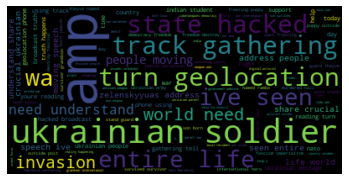

In [27]:
my_cloud = WordCloud().generate(corpus)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")

# Don't forget to show the final image
plt.show()

In [33]:
df_all['sentiment_analysis'] = df_all['text_clean_all'].swifter.apply(sentiment_scores)
df_all

NameError: name 'sentiment_scores' is not defined

In [ ]:
df_all['positive'] = df_all['sentiment_analysis'].apply(lambda row: row['pos'])
df_all['neutral'] = df_all['sentiment_analysis'].apply(lambda row: row['neu'])
df_all['negative'] = df_all['sentiment_analysis'].apply(lambda row: row['neg'])
df_all['compound'] = df_all['sentiment_analysis'].apply(lambda row: row['compound'])
df_all = df_all[df_all['country' != '']]
df_all

In [ ]:
df_all.to_pickle("./df_sentiment_20220227.pkl")
df_all.to_csv("./df_sentiment_20220227.csv")

In [ ]:
!pip install datapackage
import datapackage

data_url = 'https://datahub.io/core/geo-countries/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

In [ ]:
# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        data = pd.read_csv(resource.descriptor['path'])
        print (data)

In [ ]:
df_geo = pd.read_csv('https://datahub.io/core/geo-countries/r/0.geojson')
df_geo

In [ ]:
df_all